### Prediction of Customer Churn

In the previous notebook, we have defined the problem of customer churn and discussed why it is important for telecom companies to predict and alleviate it.

### Why Customer Churn Prediction Is Important

Customer churn prediction allows organizations to proactively approach at-risk clients and try to repair the relationship before the customer leaves. In effect it is a pre-warning that lets you act. It is generally accepted that retaining a customer costs a lot less than acquiring a new one. So being able to predict a customer is going to churn and preventing it, is better than losing them and finding another to replace them.

### Aim

To predict customers who are likely to churn.

### Objectives

We will approach this as a binary classification problem and the objectives are to -

1. Find the best binary classification model
2. Find out the most important features

In [197]:
# Import basic data processing libraries

import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [198]:
# Import models and related libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV

In [199]:
# Load the dataset
df = pd.read_csv("./data/telecom_customer_churn.csv")

Let's generate a pandas profile report to get an in-depth report of the dataset

In [200]:
profile = ProfileReport(df, title="Telecom Data Report")
profile.to_file("dataset-report/index.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [201]:
# Modify the column names
df.columns=df.columns.str.replace(" ","").str.lower()

Let's deal with null values

In [202]:
df.avgmonthlylongdistancecharges=df.avgmonthlylongdistancecharges.fillna(0.0)
df.multiplelines=df.multiplelines.fillna('no phone service')
no_internet=['internettype','onlinesecurity','onlinebackup','deviceprotectionplan','premiumtechsupport','streamingtv','streamingmovies','streamingmusic','unlimiteddata']
df[no_internet]=df[no_internet].fillna('no internet service')
df.avgmonthlygbdownload=df.avgmonthlygbdownload.fillna(0)

We can use the geographic data and the churn reason column to identify in which areas the network reception is poor and improve the network service in those areas.

The geographic aspect of it can be a separate analysis and help out the company with improving network reliability.

So we are considering only the non-geographical features to predict customer churn.

In [203]:
# Let's drop unnecessary columns

df=df.drop(columns=['customerid','churncategory','churnreason','totalrefunds','zipcode','longitude','latitude','city'])

df.shape

(7043, 30)

In [204]:
# Let's check if there are any null values
df.isnull().sum()

gender                           0
age                              0
married                          0
numberofdependents               0
numberofreferrals                0
tenureinmonths                   0
offer                            0
phoneservice                     0
avgmonthlylongdistancecharges    0
multiplelines                    0
internetservice                  0
internettype                     0
avgmonthlygbdownload             0
onlinesecurity                   0
onlinebackup                     0
deviceprotectionplan             0
premiumtechsupport               0
streamingtv                      0
streamingmovies                  0
streamingmusic                   0
unlimiteddata                    0
contract                         0
paperlessbilling                 0
paymentmethod                    0
monthlycharge                    0
totalcharges                     0
totalextradatacharges            0
totallongdistancecharges         0
totalrevenue        

In [205]:
# Let's drop the newly joined customer data to remove bias
df=df.loc[~df.customerstatus.str.contains('Join')]
df.reset_index(drop=True,inplace=True)

In [206]:
df.shape

(6589, 30)

### Feature Transformation and Scaling

1. Features having binary values are replaced by 1 and 0
2. Features having more than two uniques are encoded using a label encoder
3. Continous features are standarized using sk-learn scaler method

In [207]:
label_encoder = LabelEncoder()

# Label Encoding will be used for columns with 2 or less unique values

encoded_labels_count = 0
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            label_encoder.fit(df[col])
            df[col] = label_encoder.transform(df[col])
            encoded_labels_count += 1
print('{} columns were label encoded.'.format(encoded_labels_count))

5 columns were label encoded.


In [208]:
df['gender'] = [1 if each == 'Female' else 0 for each in df['gender']]

In [209]:
df.head()

,gender,age,married,numberofdependents,numberofreferrals,tenureinmonths,offer,phoneservice,avgmonthlylongdistancecharges,multiplelines,...,unlimiteddata,contract,paperlessbilling,paymentmethod,monthlycharge,totalcharges,totalextradatacharges,totallongdistancecharges,totalrevenue,customerstatus
0,1,37,1,0,2,9,None,1,42.39,No,...,Yes,One Year,1,Credit Card,65.6,593.30,0,381.51,974.81,1
1,0,46,0,0,0,9,None,1,10.69,Yes,...,No,Month-to-Month,0,Credit Card,-4.0,542.40,10,96.21,610.28,1
2,0,50,0,0,0,4,Offer E,1,33.65,No,...,Yes,Month-to-Month,1,Bank Withdrawal,73.9,280.85,0,134.60,415.45,0
3,0,78,1,0,1,13,Offer D,1,27.82,No,...,Yes,Month-to-Month,1,Bank Withdrawal,98.0,1237.85,0,361.66,1599.51,0
4,1,75,1,0,3,3,None,1,7.38,No,...,Yes,Month-to-Month,1,Credit Card,83.9,267.40,0,22.14,289.54,0


In [210]:
def encode_data(dataframe):
    if dataframe.dtype == "object":
        dataframe = LabelEncoder().fit_transform(dataframe)
    return dataframe

# Label Encode other columns
data = df.apply(encode_data)

In [211]:
data.head()

,gender,age,married,numberofdependents,numberofreferrals,tenureinmonths,offer,phoneservice,avgmonthlylongdistancecharges,multiplelines,...,unlimiteddata,contract,paperlessbilling,paymentmethod,monthlycharge,totalcharges,totalextradatacharges,totallongdistancecharges,totalrevenue,customerstatus
0,1,37,1,0,2,9,0,1,42.39,0,...,1,1,1,1,65.6,593.30,0,381.51,974.81,1
1,0,46,0,0,0,9,0,1,10.69,1,...,0,0,0,1,-4.0,542.40,10,96.21,610.28,1
2,0,50,0,0,0,4,5,1,33.65,0,...,1,0,1,0,73.9,280.85,0,134.60,415.45,0
3,0,78,1,0,1,13,4,1,27.82,0,...,1,0,1,0,98.0,1237.85,0,361.66,1599.51,0
4,1,75,1,0,3,3,0,1,7.38,0,...,1,0,1,1,83.9,267.40,0,22.14,289.54,0


### Dataset Splitting

In [212]:
X = data.drop(columns = "customerstatus")
y = data["customerstatus"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4, stratify =y)

#### We need to scale a few columns

In [213]:
cols_to_scale = [
    'totalcharges',
    'avgmonthlylongdistancecharges',
    'monthlycharge',
    'totalrevenue',
    'totallongdistancecharges',
    'tenureinmonths',
    'totallongdistancecharges',
    'totalextradatacharges'
]

In [214]:
# Use the standard scaled
X_train[cols_to_scale] = StandardScaler().fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = StandardScaler().fit_transform(X_test[cols_to_scale])

In [215]:
X_train.head()

,gender,age,married,numberofdependents,numberofreferrals,tenureinmonths,offer,phoneservice,avgmonthlylongdistancecharges,multiplelines,...,streamingmusic,unlimiteddata,contract,paperlessbilling,paymentmethod,monthlycharge,totalcharges,totalextradatacharges,totallongdistancecharges,totalrevenue
6587,0,21,1,0,5,1.367434,1,1,-1.337224,0,...,1,1,2,0,1,0.095715,0.979074,-0.280175,-0.761986,0.548730
1784,1,52,0,0,0,-0.976998,4,1,0.108568,1,...,1,0,0,1,1,-0.191255,-0.803533,2.407041,-0.610886,-0.798239
5049,1,21,0,0,0,-0.725809,0,1,1.258118,0,...,2,2,1,0,1,-1.461661,-0.945551,-0.280175,-0.079600,-0.777084
1100,1,51,0,0,0,0.320813,0,0,-1.473753,2,...,1,0,1,1,0,-0.326679,-0.030083,2.790929,-0.929360,-0.275128
5353,1,76,0,0,0,-1.060728,5,1,-0.642342,1,...,0,1,0,1,0,0.630962,-0.732291,-0.280175,-0.792447,-0.820472


In [216]:
X_test.head()

,gender,age,married,numberofdependents,numberofreferrals,tenureinmonths,offer,phoneservice,avgmonthlylongdistancecharges,multiplelines,...,streamingmusic,unlimiteddata,contract,paperlessbilling,paymentmethod,monthlycharge,totalcharges,totalextradatacharges,totallongdistancecharges,totalrevenue
2989,0,45,1,3,1,-1.113051,0,1,0.488738,0,...,0,1,0,0,0,-0.662423,-0.920499,-0.272466,-0.663402,-0.929002
4699,1,23,0,0,0,-1.402913,5,1,-1.185976,0,...,1,1,0,0,1,-0.620879,-1.062208,-0.272466,-0.942060,-1.124736
6584,1,36,0,0,0,-1.278686,0,1,-1.389031,0,...,2,2,0,0,0,-1.419799,-1.044867,-0.272466,-0.938684,-1.110003
5943,0,54,0,0,0,-1.154460,0,1,-0.141320,0,...,0,1,0,0,0,0.120519,-0.868103,-0.272466,-0.777066,-0.921654
4873,0,58,1,3,0,-0.906008,0,0,-1.520266,2,...,0,1,2,0,1,-0.793446,-0.823512,-0.272466,-0.947979,-0.937660


### Let's build some base models

In [217]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Kernel SVM', SVC()),
    ('KNN', KNeighborsClassifier()),
    ('Gaussian NB', GaussianNB()),
    ('Random Forest', RandomForestClassifier()),
    ('Decision Tree Classifier', DecisionTreeClassifier()),
]

In [218]:
acc_results =[]
auc_results =[]
pre_results =[]
f1_results =[]
names = []

result_col = ["Algorithm", "ROC AUC", "Accuracy", "Precision", "f1 Score"]

In [219]:
from sklearn.model_selection import cross_val_score

model_results = pd.DataFrame(columns = result_col)

for (i, (name, model)) in enumerate(models):
    names.append(name)
    
    cv_acc_results = cross_val_score(model, X_train, y_train, scoring="accuracy")
    cv_auc_results = cross_val_score(model, X_train, y_train, scoring="roc_auc")
    cv_pre_results = cross_val_score(model, X_train, y_train, scoring="precision")
    cv_f1_results = cross_val_score(model, X_train, y_train, scoring="f1")
    
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    pre_results.append(cv_pre_results)
    f1_results.append(cv_f1_results)
    
    model_results.loc[i] = [
        name, 
        round(cv_acc_results.mean()*100,2),
        round(cv_auc_results.mean()*100,2),
        round(cv_pre_results.mean()*100,2),
        round(cv_f1_results.mean()*100,2)
    ]

model_results.sort_values(by = ['ROC AUC'], ascending=False)

,Algorithm,ROC AUC,Accuracy,Precision,f1 Score
4,Random Forest,86.95,92.06,88.40,91.06
0,Logistic Regression,83.96,90.66,89.00,88.76
5,Decision Tree Classifier,81.29,77.37,87.68,87.18
1,Kernel SVM,79.27,86.18,80.52,86.63
3,Gaussian NB,76.87,86.19,91.32,82.23
2,KNN,75.43,78.87,82.60,82.90


#### Comments

- With just the base Random Forest Model we are getting 86.6% ROC AUC score and an f1 score of 91%.
- These models are pretty good but let's try and **tune hyper parameters** for each of them.

In [220]:
c_green = '#3A616D'
c_off_white = '#F0E4CE'
c_orange = '#FA8072'

#### Decision Tree

In [221]:
modelD= DecisionTreeClassifier()
modelD.fit(X_train, y_train)

pred_train_D = modelD.predict(X_train)
pred_test_D=modelD.predict(X_test)

acc_train_D = accuracy_score(pred_train_D, y_train)
acc_test_D = accuracy_score(pred_test_D, y_test)

print(f'Training accuracy {acc_train_D*100: .3f}%') 
print(f'Testing accuracy {acc_test_D*100: .3f}%')

Training accuracy  100.000%
Testing accuracy  83.915%


In [222]:
# Let's tune the hyper parameters parameters
tuned_parameters = [{'criterion':['gini', 'entropy'], 'max_leaf_nodes': range(5, 45)}]

# grid search model
clf_D = GridSearchCV(DecisionTreeClassifier(), tuned_parameters, verbose=1, n_jobs=-1)
# evaluate hyper-parameters
clf_D.fit(X_train, y_train)

means_D = clf_D.cv_results_['mean_test_score'] # mean accuracy with folds
stds_D = clf_D.cv_results_['std_test_score'] # standard deviation of accuracies

data_x = np.arange(5, 45)
data_y = {
    'gini': [],
    'entropy': []
}
for mean, std, params in zip(means_D, stds_D, clf_D.cv_results_['params']):
    data_y[params['criterion']].append(mean)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


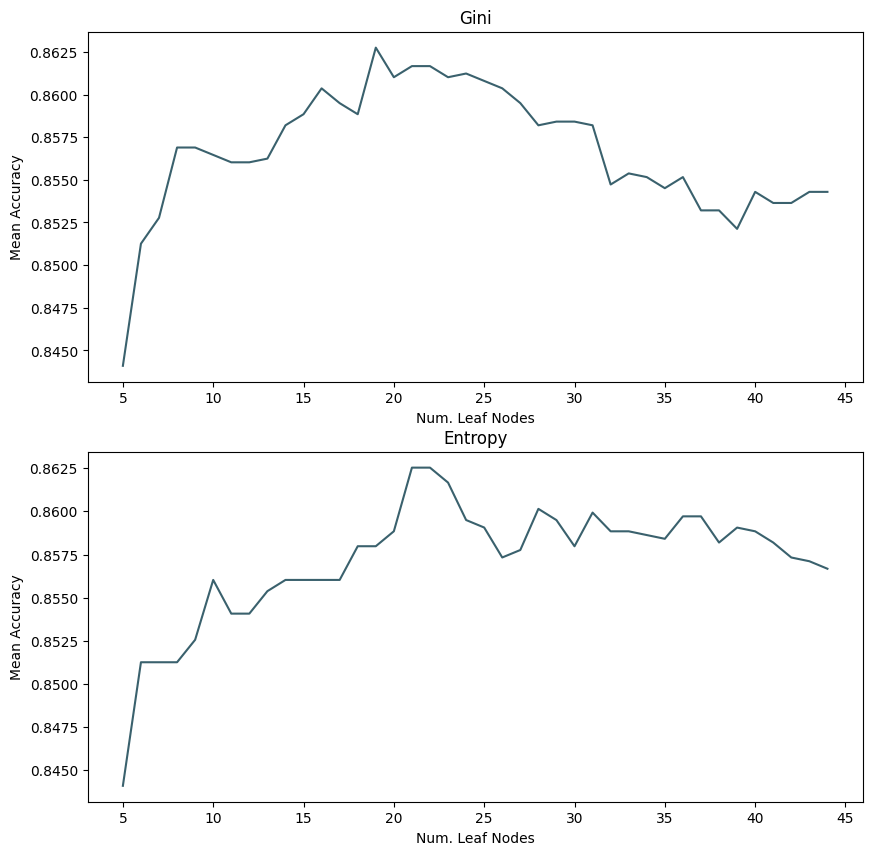

In [223]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(data_x, data_y['gini'], label='gini', color=c_green)
ax1.set_title('Gini')
ax1.set_ylabel('Mean Accuracy')
ax1.set_xlabel('Num. Leaf Nodes')

ax2.plot(data_x, data_y['entropy'], label='gini', color=c_green)
ax2.set_title('Entropy')
ax2.set_ylabel('Mean Accuracy')
ax2.set_xlabel('Num. Leaf Nodes')

# set size of plot
fig.set_size_inches(10, 10)
fig.show()

In [224]:
print("Best parameters found:")
print(clf_D.best_params_)

Best parameters found:
{'criterion': 'gini', 'max_leaf_nodes': 19}


DecisionTreeClassifier(max_leaf_nodes=19)
Results on test data
Test accuracy =  0.8553
Test precision =  0.8655
Test recall =  0.9449
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       561
           1       0.87      0.94      0.90      1416

    accuracy                           0.86      1977
   macro avg       0.84      0.79      0.81      1977
weighted avg       0.85      0.86      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  353   208
1   78  1338
ROC curve


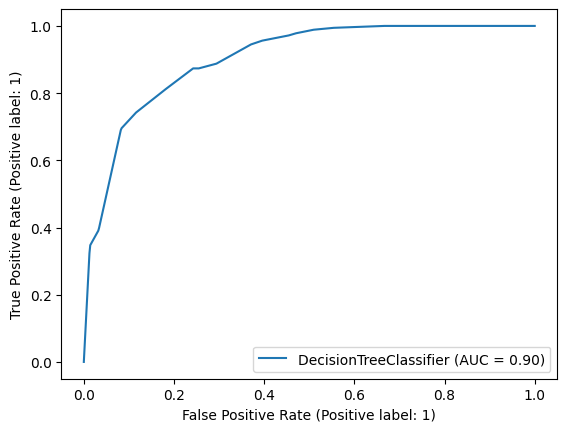

In [225]:
criterion = clf_D.best_params_['criterion']
max_leaf_nodes = clf_D.best_params_['max_leaf_nodes']
# Train and test model
good_model_D = DecisionTreeClassifier(criterion=criterion, max_leaf_nodes=max_leaf_nodes)
print(good_model_D)

good_model_D.fit(X_train, y_train)
pred_D = good_model_D.predict(X_test)
print("Results on test data")

acc_D = accuracy_score(y_test, pred_D)
prec_D = precision_score(y_test, pred_D)
reca_D = recall_score(y_test, pred_D)

print(f'Test accuracy = {acc_D: .4f}')
print(f'Test precision = {prec_D: .4f}')
print(f'Test recall = {reca_D: .4f}')

print("Classification report:")
print(classification_report(y_test, pred_D))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred_D)))

print('ROC curve')
plot_roc_curve(good_model_D, X_test, y_test) 

plt.show()

#### Random Forest

In [226]:
modelR = RandomForestClassifier()

modelR.fit(X_train, y_train) 

pred_train = modelR.predict(X_train)
pred_test=modelR.predict(X_test)

acc_train = accuracy_score(pred_train, y_train)
acc_test = accuracy_score(pred_test, y_test)

print(f'Training accuracy {acc_train * 100: .3f}%') 
print(f'Testing accuracy {acc_test * 100: .3f}%')

Training accuracy  100.000%
Testing accuracy  87.304%


In [227]:
n_estimators = [25, 50, 75]
max_features = [15, 20, 25]
max_leaf_nodes = [8, 16, 24]
tuned_parameters = [{'n_estimators': n_estimators,'max_features': max_features,'max_leaf_nodes': max_leaf_nodes}]

clfR = GridSearchCV(RandomForestClassifier(), tuned_parameters, verbose=1, n_jobs=-1)
clfR.fit(X_train, y_train)

means = clfR.cv_results_['mean_test_score'] # mean accuracy with folds
stds = clfR.cv_results_['std_test_score'] # standard deviation of accuracies

print("Best parameters found:")
print(clfR.best_params_)

# best score
print("Best score:")
print(clfR.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters found:
{'max_features': 20, 'max_leaf_nodes': 24, 'n_estimators': 25}
Best score:
0.8735936056855064


RandomForestClassifier(max_features=15, max_leaf_nodes=16, n_estimators=50)
Results on test data
Test accuracy =  0.8609
Test precision =  0.8674
Test recall =  0.9513
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.63      0.72       561
           1       0.87      0.95      0.91      1416

    accuracy                           0.86      1977
   macro avg       0.85      0.79      0.81      1977
weighted avg       0.86      0.86      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  355   206
1   69  1347
ROC curve


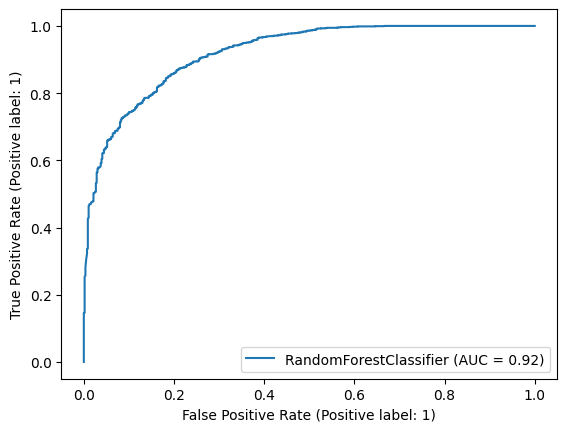

In [228]:
max_features = 15
max_leaf_nodes = 16 
n_estimators = 50

good_model = RandomForestClassifier(max_leaf_nodes = max_leaf_nodes, max_features = max_features, n_estimators=n_estimators)
print(good_model)

good_model.fit(X_train, y_train)
pred = good_model.predict(X_test)

print("Results on test data")
acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred)
reca = recall_score(y_test, pred)

print(f'Test accuracy = {acc: .4f}')
print(f'Test precision = {prec: .4f}')
print(f'Test recall = {reca: .4f}')

print("Classification report:")
print(classification_report(y_test, pred))

print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred)))

print('ROC curve')
plot_roc_curve(good_model, X_test, y_test)
plt.show()

#### Logistic Regression

In [229]:
modelL = LogisticRegression()

modelL.fit(X_train,y_train)

pred_trainL = modelL.predict(X_train)
pred_testL=modelL.predict(X_test)

acc_trainL = accuracy_score(pred_trainL, y_train)
acc_testL = accuracy_score(pred_testL, y_test)
print(f'Training accuracy {acc_trainL * 100: .3f}%') 
print(f'Testing accuracy {acc_testL * 100: .3f}%')

Training accuracy  84.670%
Testing accuracy  85.787%


In [230]:
tuned_parameters = [{'C': [10.0, 100.0, 1000.0, 10000.0],'max_iter': [500, 1000]}]

clfL = GridSearchCV(LogisticRegression(), tuned_parameters, verbose=1, n_jobs=-1)
clfL.fit(X_train,y_train) # evaluate hyper-parameters

meansL = clfL.cv_results_['mean_test_score'] # mean accuracy with folds
stdsL = clfL.cv_results_['std_test_score'] # standard deviation of accuracies

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/sid/Desktop/research project/.env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/sid/Desktop/research project/.env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Text(0.5, 0, 'C')

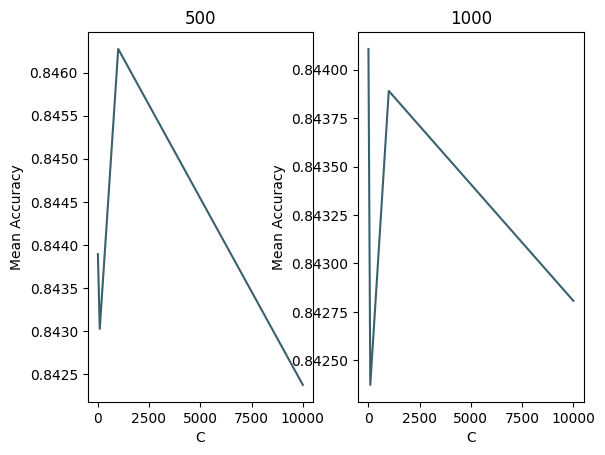

In [231]:
# generate a plot of accuracy vs combinations of hyper parameters
data_x = [10.0, 100.0, 1000.0, 10000.0]
data_y = {'500': meansL[0:4], '1000': meansL[4:8]}

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(data_x, data_y['500'], label='gini', color=c_green)
ax1.set_title('500')
ax1.set_ylabel('Mean Accuracy')
ax1.set_xlabel('C')

ax2.plot(data_x, data_y['1000'], label='gini', color=c_green)
ax2.set_title('1000')
ax2.set_ylabel('Mean Accuracy')
ax2.set_xlabel('C')

In [232]:
print("\nBest parameters found:")
print(clfL.best_params_) # best hyperparameter values


Best parameters found:
{'C': 100.0, 'max_iter': 500}


LogisticRegression(C=1000, max_iter=1000)
Results on test data
Test accuracy =  0.8543
Test precision =  0.8989
Test recall =  0.8976
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       561
           1       0.90      0.90      0.90      1416

    accuracy                           0.85      1977
   macro avg       0.82      0.82      0.82      1977
weighted avg       0.85      0.85      0.85      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  418   143
1  145  1271
ROC curve


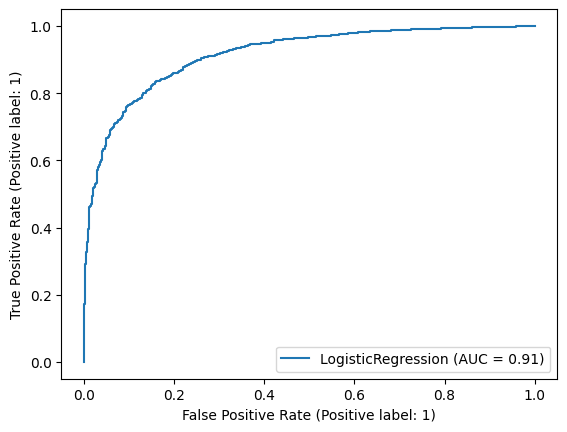

In [233]:
C = 1000
max_iter = 1000

good_modelL = LogisticRegression(C = C, max_iter=max_iter)
print(good_modelL)

good_modelL.fit(X_train,y_train)
predL = good_modelL.predict(X_test)

print("Results on test data")
accL = accuracy_score(y_test, predL)
precL = precision_score(y_test, predL)
recaL = recall_score(y_test, predL)

print(f'Test accuracy = {accL: .4f}')
print(f'Test precision = {precL: .4f}')
print(f'Test recall = {recaL: .4f}')

print("Classification report:")
print(classification_report(y_test, predL))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, predL)))

print('ROC curve')
plot_roc_curve(good_modelL, X_test, y_test)
plt.show()

#### K Nearest Neighbors

In [234]:
modelknn= KNeighborsClassifier().fit(X_train,y_train)

pred_trainknn = modelknn.predict(X_train)
pred_testknn=modelknn.predict(X_test)

acc_trainknn = accuracy_score(pred_trainknn, y_train)
acc_testknn = accuracy_score(pred_testknn, y_test)
print(f'Training accuracy: {acc_trainknn * 100: .3f}%') 
print(f'Testing accuracy: {acc_testknn * 100: .3f}%')

Training accuracy:  84.345%
Testing accuracy:  78.756%


Fitting 5 folds for each of 6 candidates, totalling 30 fits

Grid scores:


Text(0.5, 0, 'n_neighbors')

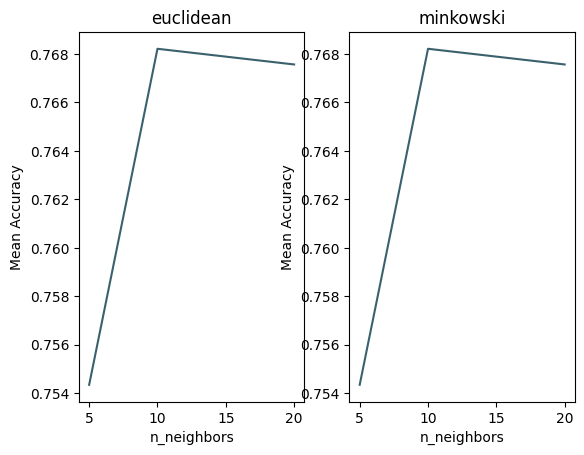

In [235]:
tuned_parameters = [{
    'algorithm':['brute'],
    'metric': ['euclidean', 'minkowski'],
    'n_neighbors': [5, 10, 20]
}]

clfknn = GridSearchCV(KNeighborsClassifier(), tuned_parameters,verbose=1, n_jobs=-1)
clfknn.fit(X_train, y_train)

print("\nGrid scores:")
meansknn = clfknn.cv_results_['mean_test_score']
stdsknn = clfknn.cv_results_['std_test_score']

# plot mean accuracy (meansknn) vs n_neighbors grouped by metric
data_x = [5, 10, 20]
data_y = {'euclidean': meansknn[0:3], 'minkowski': meansknn[3:6]}

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(data_x, data_y['euclidean'], label='gini', color=c_green)
ax1.set_title('euclidean')
ax1.set_ylabel('Mean Accuracy')
ax1.set_xlabel('n_neighbors')

ax2.plot(data_x, data_y['minkowski'], label='gini', color=c_green)
ax2.set_title('minkowski')
ax2.set_ylabel('Mean Accuracy')
ax2.set_xlabel('n_neighbors')


In [236]:
print("\n\nBest parameters found:")
print(clfknn.best_params_)



Best parameters found:
{'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 10}


KNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=20)
Results on test data
Test accuracy =  0.7820
Test precision =  0.8385
Test recall =  0.8616
Classification report:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       561
           1       0.84      0.86      0.85      1416

    accuracy                           0.78      1977
   macro avg       0.73      0.72      0.73      1977
weighted avg       0.78      0.78      0.78      1977

Confusion matrix (Rows actual, Columns predicted):
     0     1
0  326   235
1  196  1220
ROC curve


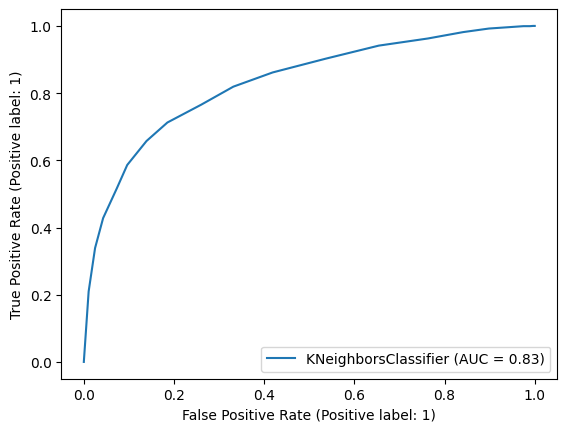

In [237]:
algorithm = 'brute'
metric = 'euclidean'
n_neighbors =  20

good_modelknn = KNeighborsClassifier(algorithm=algorithm, metric=metric, n_neighbors=n_neighbors)
print(good_modelknn)

good_modelknn.fit(X_train, y_train)
predknn = good_modelknn.predict(X_test)

print("Results on test data")
accknn = accuracy_score(y_test, predknn)
precknn = precision_score(y_test, predknn)
recaknn = recall_score(y_test, predknn)

print(f'Test accuracy = {accknn: .4f}')
print(f'Test precision = {precknn: .4f}')
print(f'Test recall = {recaknn: .4f}')

print("Classification report:")
print(classification_report(y_test, predknn))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, predknn)))

print('ROC curve')
plot_roc_curve(good_modelknn, X_test, y_test) 
plt.show()

#### Support Vector Machines

In [238]:
modelsvm=svm.SVC().fit(X_train,y_train)

pred_trainsvm = modelsvm.predict(X_train)
pred_testsvm=modelsvm.predict(X_test)

acc_trainsvm = accuracy_score(pred_trainsvm, y_train)
acc_testsvm = accuracy_score(pred_testsvm, y_test)
print(f'Training accuracy: {acc_trainsvm * 100: .3f}%')
print(f'Testing accuracy: {acc_testsvm * 100: .3f}%')

Training accuracy:  80.703%
Testing accuracy:  80.324%


In [239]:
tuned_parameters = [{'kernel':['linear'], 'gamma': np.arange(0.1, 1, 0.1), 'C': np.arange(0.1, 1, 0.1)}]

clfsvm = GridSearchCV(svm.SVC(), tuned_parameters, verbose=1, n_jobs=-1)
clfsvm.fit(X_train,y_train) # evaluate hyper-parameters

meansvm = clfsvm.cv_results_['mean_test_score']
stdsvm = clfsvm.cv_results_['std_test_score']

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
print("\nBest parameters found:")
print(clfsvm.best_params_)

# print best accuracy score
print(f'Best accuracy: {clfsvm.best_score_ * 100: .3f}%')

In [ ]:
C = 0.4
kernel = 'linear'
gamma =  0.1

good_modelsvm = svm.SVC(C=C, kernel=kernel, gamma=gamma)
print(good_modelsvm)

good_modelsvm.fit(X_train,y_train)
predsvm = good_modelsvm.predict(X_test)

print("Results on test data")
accsvm = accuracy_score(y_test, predsvm)
precsvm = precision_score(y_test, predsvm)
recasvm = recall_score(y_test, predsvm)

print(f'Test accuracy = {accsvm: .4f}')
print(f'Test precision = {precsvm: .4f}')
print(f'Test recall = {recasvm: .4f}')

print("Classification report:")
print(classification_report(y_test, predsvm))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, predsvm)))

print('ROC curve')
plot_roc_curve(good_modelsvm, X_test, y_test)
plt.show()

#### List all tuned models

In [ ]:
models_tuned = [
    (
        'Logistic Regression',
        LogisticRegression(solver='liblinear',C = 1000, max_iter=1000, random_state = 0)
    ),
    (
        'SVC',
        SVC(C=0.4, kernel = 'linear', gamma=0.1, random_state = 0)
    ),
    (
        'Kernel SVM',
        SVC(C=0.4, kernel = 'rbf', gamma=0.1, random_state = 0)
    ),
    (
        'KNN',
        KNeighborsClassifier(n_neighbors = 10, metric = 'euclidean', p = 2, algorithm='brute')
    ),
    (
        'Gaussian NB',
        GaussianNB()
    ),
    (
        'Decision Tree Classifier',
        DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = 19, random_state = 0)
    ),
    (
        'Random Forest',
        RandomForestClassifier(max_leaf_nodes = 24, max_features = 15, n_estimators = 25, criterion = 'entropy', random_state = 0)
    )
]

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

acc_results_opt =[]
auc_results_opt =[]
pre_results_opt =[]
f1_results_opt =[]
names_opt = []

result_col_opt = ["Algorithm", "ROC AUC", "Accuracy", 'Precision', 'F1 Scores']
model_results_opt = pd.DataFrame(columns = result_col_opt)

for (i, (name, model)) in enumerate(models):
    names_opt.append(name)
    kfold = KFold(n_splits=10)
    
    cv_acc_results_opt = cross_val_score(model, X_train, y_train,  cv = kfold, scoring="accuracy")
    cv_auc_results_opt = cross_val_score(model, X_train, y_train, cv = kfold, scoring="roc_auc")
    cv_pre_results_opt = cross_val_score(model, X_train, y_train, cv = kfold, scoring="precision")
    cv_f1_results_opt = cross_val_score(model, X_train, y_train, cv = kfold, scoring="f1")
    
    acc_results_opt.append(cv_acc_results_opt)
    auc_results_opt.append(cv_auc_results_opt)
    pre_results_opt.append(cv_pre_results_opt)
    f1_results_opt.append(cv_f1_results_opt)
    
    model_results_opt.loc[i] = [
        name, 
        round(cv_auc_results_opt.mean()*100,2),
        round(cv_acc_results_opt.mean()*100,2),
        round(cv_pre_results_opt.mean()*100,2),
        round(cv_f1_results_opt.mean()*100,2)
    ]

model_results_opt.sort_values(by = ['ROC AUC'], ascending=False)

#### Best Model - Random Forest

The random forest model turns out to be the best with highest ROC AUC, accuracy, and f1-score

Let's try and apply permutation importance and partial distance on Random Forest

#### Permutation Importance

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(good_model, random_state=1).fit(X_test, y_test)
eli5.explain_weights(perm, feature_names = X_test.columns.tolist(), top=10)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

data1 = data.query('monthlycharge >= 0')
y1 = data.customerstatus

base_features=['tenureinmonths','contract','numberofreferrals','age','numberofdependents','monthlycharge']
X1 = data[base_features]

train_X1, val_X1, train_y1, val_y1 = train_test_split(X1, y1, random_state=1)
first_model = RandomForestRegressor(n_estimators=50, random_state=1).fit(train_X1, train_y1)

print("Data sample:")
data.head()

#### Applying Partial Distance Plots

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

In [ ]:
PartialDependenceDisplay.from_estimator(first_model, val_X1, base_features, kind='average')
plt.gcf().set_size_inches(10, 8)

#### Important Features

Contract and Tenure In Months are the most important features

In [ ]:
imp_features = ['contract', 'tenureinmonths']

max_features = 15
max_leaf_nodes = 24
n_estimators = 25

good_model = RandomForestClassifier(max_leaf_nodes = max_leaf_nodes, max_features = max_features, n_estimators=n_estimators)

print(good_model)
good_model.fit(X_train, y_train)
pred = good_model.predict(X_test)

print("Results on test data")
acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred)
reca = recall_score(y_test, pred)

print(f'Test accuracy = {acc: .4f}')
print(f'Test precision = {prec: .4f}')
print(f'Test recall = {reca: .4f}')

print("Classification report:")
print(classification_report(y_test, pred))
print("Confusion matrix (Rows actual, Columns predicted):")
print(pd.DataFrame(confusion_matrix(y_test, pred)))

print('ROC curve')
plot_roc_curve(good_model, X_test, y_test)
plt.show()

In [ ]:
perm = PermutationImportance(good_modelL, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=10)

### Conclusion

Random Forest model is the best

#### MOST IMPORTANT FEATURES ARE
1. CONTRACT
2. MONTHLY CHARGE
3. TENURE IN MONTHS
4. NUMBER OF REFERRALS
5. NUMBER OF INDEPENDENTS